In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random square wave signal with random parameters
def generate_random_square_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * (1 - 2 * (np.floor(frequency * t) % 2))
    return signal

# Generate a random sawtooth signal with random parameters
def generate_random_sawtooth_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * (2 * (frequency * t - np.floor(frequency * t + 0.5)))
    return signal

# Generate a random noisy signal with random parameters
def generate_random_noisy_signal(length):
    amplitude = np.random.uniform(0.5, 2)
    noise_level = np.random.uniform(0.05, 0.5)
    signal = amplitude * np.random.rand(length) + noise_level * np.random.randn(length)
    return signal

# Generate a random sinusoidal signal with random parameters
def generate_random_sinusoidal_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * np.sin(2 * np.pi * frequency * t)
    return signal

# Generate a random affine (ramp) signal with random parameters
def generate_random_affine_signal(length):
    slope = np.random.uniform(0.2, 2)
    intercept = np.random.uniform(-0.2, 0.2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = slope * t + intercept
    return signal


In [3]:
signal_length = 1000

# Specify the number of signals for each type
num_square_signals = 5
num_sawtooth_signals = 4
num_noisy_signals = 3
num_sinusoidal_signals = 2
num_affine_signals = 1

# Generate signals for each type
square_signals = [generate_random_square_signal(signal_length) for _ in range(num_square_signals)]
square_signals = np.array(square_signals)
sawtooth_signals = [generate_random_sawtooth_signal(signal_length) for _ in range(num_sawtooth_signals)]
sawtooth_signals = np.array(sawtooth_signals)
noisy_signals = [generate_random_noisy_signal(signal_length) for _ in range(num_noisy_signals)]
noisy_signals = np.array(noisy_signals)
sinusoidal_signals = [generate_random_sinusoidal_signal(signal_length) for _ in range(num_sinusoidal_signals)]
sinusoidal_signals = np.array(sinusoidal_signals)
affine_signals = [generate_random_affine_signal(signal_length) for _ in range(num_affine_signals)]
affine_signals = np.array(affine_signals)


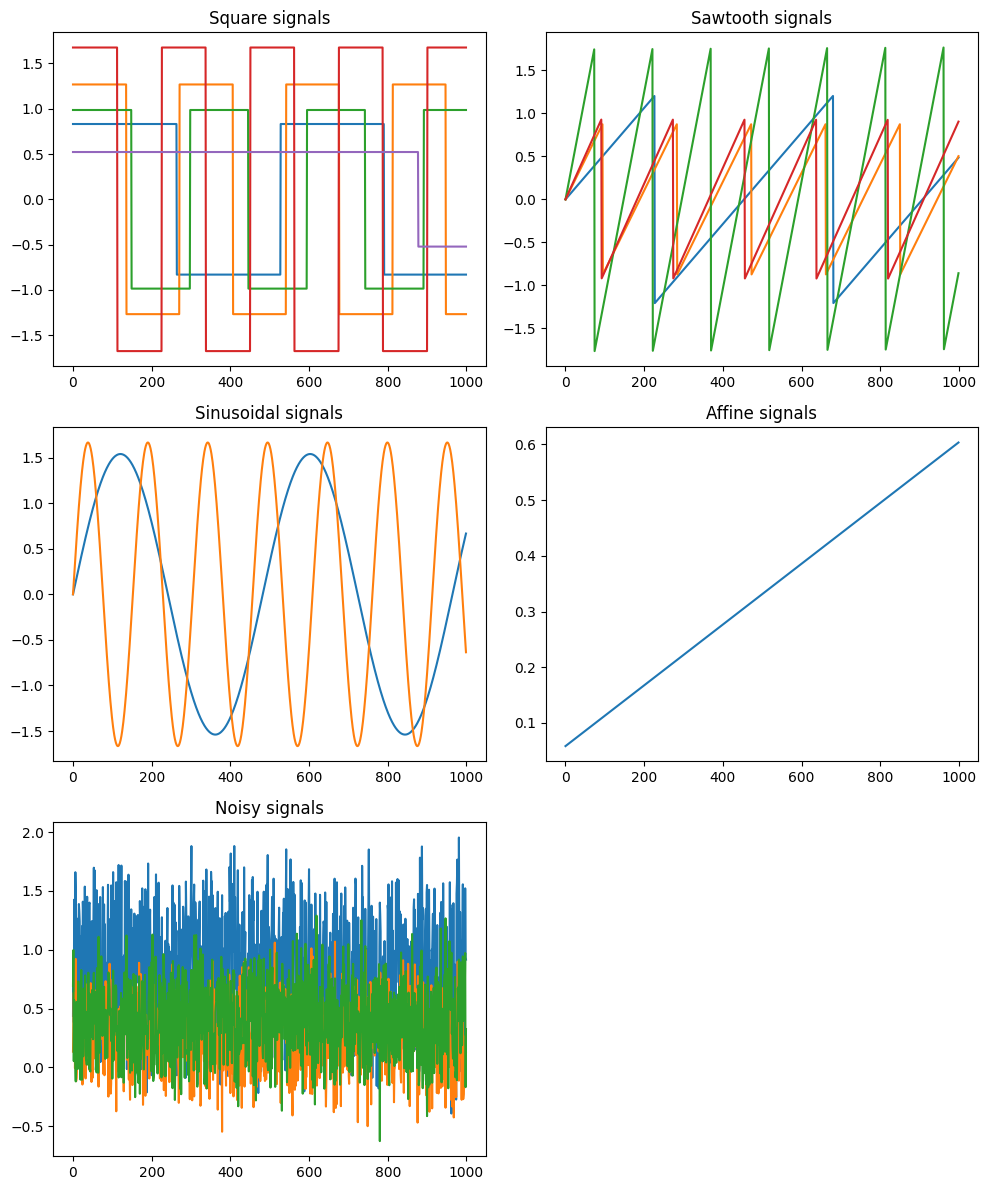

In [4]:
import matplotlib.pyplot as plt

# Plot the signals
plt.figure(figsize=(10, 12))  # Adjust the figure size to accommodate the extra subplot

# Square signals
plt.subplot(3, 2, 1)
for signal in square_signals:
    plt.plot(signal)
plt.title('Square signals')

# Sawtooth signals
plt.subplot(3, 2, 2)
for signal in sawtooth_signals:
    plt.plot(signal)
plt.title('Sawtooth signals')

# Sinusoidal signals
plt.subplot(3, 2, 3)
for signal in sinusoidal_signals:
    plt.plot(signal)
plt.title('Sinusoidal signals')

# Affine signals
plt.subplot(3, 2, 4)
for signal in affine_signals:
    plt.plot(signal)
plt.title('Affine signals')

# Noisy signals
plt.subplot(3, 2, 5)
for signal in noisy_signals:
    plt.plot(signal)
plt.title('Noisy signals')

plt.tight_layout()
plt.show()


In [5]:
# divide those signal in sub signal
sub_signal_length = 100
sinusoidal_signals = sinusoidal_signals.reshape(-1, sub_signal_length)
square_signals = square_signals.reshape(-1, sub_signal_length)
sawtooth_signals = sawtooth_signals.reshape(-1, sub_signal_length)
noisy_signals = noisy_signals.reshape(-1, sub_signal_length)
affine_signals = affine_signals.reshape(-1, sub_signal_length)


In [17]:
# create the model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Simple_LSTM_Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Simple_LSTM_Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout,batch_first=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (seq_len, batch, input_size)
        # h0: (num_layers, batch, hidden_size)
        # c0: (num_layers, batch, hidden_size)
        output, (hn, cn) = self.lstm(x)
        # keep only the last output of the sequence
        output = output[:, -1, :]


        return output

class Simple_LSTM_Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout,sequence_length):
        super(Simple_LSTM_Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.sequence_length = sequence_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout,batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x: (1,latent_dim)
        # repeat x to match the input size of the lstm

        batch_size = x.shape[0]
        x = x.repeat(self.sequence_length,1,1)

        x = x.permute(1,0,2)

        # x: (1, batch, input_size)
        output, (hn, cn) = self.lstm(x)



        # keep all the outputs of the sequence

        return output

In [18]:
# create a random tensor
latent_dim = 100
model_encoder = Simple_LSTM_Encoder(input_size=1, hidden_size=latent_dim, num_layers=1, dropout=0)
random_input = torch.randn(100, 50, 1)
print(f'input shape: {random_input.shape}')
output = model_encoder(random_input)
print(f'output shape: {output.shape}')
model_decoder = Simple_LSTM_Decoder(input_size=latent_dim, hidden_size=1, num_layers=1, dropout=0,sequence_length=50)
output = model_decoder(output)
print(f'output shape: {output.shape}')

input shape: torch.Size([100, 50, 1])
output shape: torch.Size([100, 100])
output shape: torch.Size([100, 50, 1])


In [13]:
# try with sinusoidal signal
signal_to_tensor = torch.from_numpy(sinusoidal_signals).float().unsqueeze(2)
print(f'signal_to_tensor shape: {signal_to_tensor.shape}')
signal_length = signal_to_tensor.shape[1]
model_encoder = Simple_LSTM_Encoder(input_size=1, hidden_size=10, num_layers=1, dropout=0)
model_decoder = Simple_LSTM_Decoder(input_size=10, hidden_size=1, num_layers=1, dropout=0,sequence_length=signal_length)
output_encoder = model_encoder(signal_to_tensor)
output_decoder = model_decoder(output_encoder)
print(f'output_encoder shape: {output_encoder.shape}')
print(f'output_decoder shape: {output_decoder.shape}')



signal_to_tensor shape: torch.Size([20, 100, 1])
output_encoder shape: torch.Size([20, 10])
output_decoder shape: torch.Size([20, 100, 1])


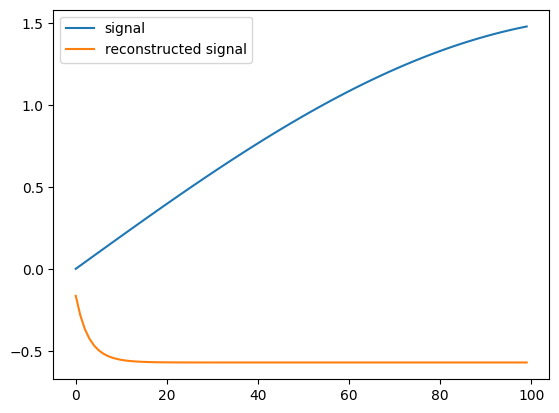

In [14]:
# plot the reconstruction
output_encoder = model_encoder(signal_to_tensor)
output_decoder = model_decoder(output_encoder)
# take the first signal
signal = signal_to_tensor[0].squeeze().detach().numpy()
reconstructed_signal = output_decoder[0].squeeze().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(reconstructed_signal, label='reconstructed signal')
plt.legend()
plt.show()


In [15]:
# try a simple overfitting
optimizer = torch.optim.Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()
    output_encoder = model_encoder(signal_to_tensor)
    output_decoder = model_decoder(output_encoder)
    loss = loss_fn(output_decoder, signal_to_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 1.5667707920074463
Epoch: 100, loss: 1.1552988290786743
Epoch: 200, loss: 0.9205400347709656
Epoch: 300, loss: 0.9228353500366211
Epoch: 400, loss: 0.9058840274810791
Epoch: 500, loss: 0.9049487113952637
Epoch: 600, loss: 0.797163724899292
Epoch: 700, loss: 0.7865055799484253
Epoch: 800, loss: 0.7375547289848328
Epoch: 900, loss: 0.7030099034309387


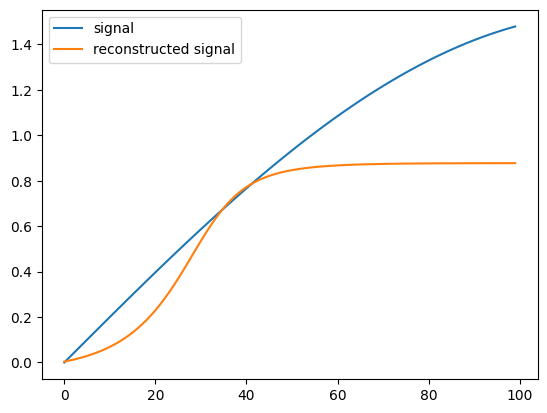

In [16]:
# plot the reconstruction
output_encoder = model_encoder(signal_to_tensor)
output_decoder = model_decoder(output_encoder)
# take the first signal
signal = signal_to_tensor[0].squeeze().detach().numpy()
reconstructed_signal = output_decoder[0].squeeze().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(reconstructed_signal, label='reconstructed signal')
plt.legend()
plt.show()
